In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
from dictys.net import stat
import joblib
import pickle
from scipy.stats import median_abs_deviation, hypergeom
import math

In [2]:
from utils_custom import *

In [3]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files'
data_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(data_folder, 'dynamic.h5'))

### Expression dynamics

In [8]:
# get lcpm chars for these genes
lcpm_dcurve_pb, dtime_pb = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=2, num=20, dist=0.001, mode="expression")
# get lcpm chars for these genes
lcpm_dcurve_gc, dtime_gc = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=3, num=20, dist=0.001, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
display(lcpm_dcurve_gc.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
A1BG,4.593149,4.601621,4.605263,4.602691,4.592258,4.572255,4.541346,4.499248,4.447430,4.389380,4.330017,4.274354,4.226111,4.187051,4.157162,4.135317,4.119941,4.109471,4.102570,4.098193
A1BG-AS1,3.797306,3.799574,3.800765,3.800776,3.799502,3.796864,3.792875,3.787699,3.781707,3.775446,3.769526,3.764448,3.760484,3.757655,3.755811,3.754721,3.754156,3.753924,3.753880,3.753925
AAAS,4.328364,4.325487,4.326282,4.331942,4.343878,4.363547,4.392074,4.429683,4.475099,4.525339,4.576221,4.623512,4.664099,4.696546,4.720920,4.738232,4.749858,4.757158,4.761290,4.763162
AACS,4.725058,4.759460,4.793856,4.828513,4.863690,4.899525,4.935872,4.972139,5.007226,5.039675,5.068068,5.091470,5.109682,5.123165,5.132767,5.139423,5.143968,5.147059,5.149173,5.150638
AAGAB,5.647568,5.651756,5.657722,5.666067,5.677525,5.692884,5.712795,5.737468,5.766351,5.797975,5.830188,5.860740,5.887904,5.910813,5.929396,5.944106,5.955621,5.964639,5.971766,5.977492


### Regulation dynamics


In [9]:
pts, fsmooth = dictys_dynamic_object.linspace(0,3,20,0.001)
stat1_net = fsmooth(stat.net(dictys_dynamic_object)) #varname=w_in loads total effect network
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])

# Get episode specific GRN (transient state specific)

In [86]:
# pts is a dictys traj object
dnetbin = stat1_netbin.compute(pts)
dnetbin_episode = dnetbin[:, :, 15:20] #5 timepoints, excludes the last one

In [87]:
# compute the weighted network
dnet = stat1_net.compute(pts)
dnet_episode = dnet[:, :, 15:20]
display(dnet_episode)

array([[[-7.23938711e-02, -7.57892969e-02, -7.84714357e-02,
         -8.06111569e-02, -8.23476968e-02],
        [-5.35747085e-02, -5.56105846e-02, -5.73533807e-02,
         -5.88745659e-02, -6.02311726e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 1.22138167e-01,  1.22854652e-01,  1.23596266e-01,
          1.24350581e-01,  1.25105339e-01],
        [ 7.09937649e-02,  7.33153072e-02,  7.50586766e-02,
          7.63583923e-02,  7.73237887e-02]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.0000000

### Filter episodic GRN edges which are significantly non-zero across time points and are direction invariant

In [88]:
###### Get the tf and target names #####
# Create reverse mapping: index -> gene_name
ndict = dictys_dynamic_object.ndict
index_to_gene = {idx: name for name, idx in ndict.items()}
target_names = [index_to_gene[idx] for idx in range(dnetbin_episode.shape[1])]
# Get TF_gene_indices from TFs_to_keep_indices using nids[0]
tf_gene_indices = [dictys_dynamic_object.nids[0][tf_idx] for tf_idx in range(dnetbin_episode.shape[0])]
tf_names = [index_to_gene[idx] for idx in tf_gene_indices]
print(len(target_names))
print(len(tf_names))

11907
551


In [89]:
###### Create multi-index tuples (all combinations of TF-target pairs) ######
index_tuples = [(tf, target) for tf in tf_names for target in target_names]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = dnet_episode.shape
reshaped_data = dnet_episode.reshape(-1, n_times)
# Create DataFrame with multi-index
episode_beta_dcurve = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
# drop rows that are all 0
episode_beta_dcurve = episode_beta_dcurve[episode_beta_dcurve.sum(axis=1) != 0]
# the number of edges here remain the same between episodes, indicating that exact 0 are the edges that don't have atac-seq basis
display(episode_beta_dcurve.head())
display(episode_beta_dcurve.shape)

time_0    time_1    time_2    time_3    time_4
TF  Target                                                    
AHR A1BG     -0.072394 -0.075789 -0.078471 -0.080611 -0.082348
    A1BG-AS1 -0.053575 -0.055611 -0.057353 -0.058875 -0.060231
    AAGAB     0.000117  0.000076  0.000049  0.000031  0.000020
    AAK1      0.021684  0.020096  0.018950  0.018132  0.017546
    AAMDC     0.000176  0.000113  0.000072  0.000045  0.000028

(1612764, 5)

In [90]:
###### Filtering the global episodic GRN for retaining significantly non-zero and direction invariant edges ######
filtered_edges = filter_edges_by_significance_and_direction(
    episode_beta_dcurve,
    min_nonzero_timepoints=3,
    alpha=0.05,
    min_observations=3,
    check_direction_invariance=True,  # Enable direction invariance check
    n_processes=60,
    chunk_size=8000,
    save_intermediate=False,
    intermediate_path=output_folder
)
    
print(f"\nFinal shape: {filtered_edges.shape}")

# Save result
print("Saving results...")
filtered_edges.to_parquet(os.path.join(output_folder, "filtered_edges_significant_invariant_GC_ep4.parquet"))
print("Results saved!")

Processing 1,612,764 rows using 60 processes...
Chunk size: 8,000 rows
Direction invariance check: Enabled
Time columns: ['time_0', 'time_1', 'time_2', 'time_3', 'time_4']
Creating index chunks...
Created 202 chunks of indices


Processing chunks: 100%|██████████| 202/202 [00:46<00:00,  4.33it/s]


Processing completed in 49.49 seconds
Sorting results...
Creating result DataFrame...

Final shape: (1471128, 6)
Saving results...
Results saved!


In [91]:
# load episode parquet file into pandas
#filtered_edges = pd.read_parquet('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/filtered_edges_significant_invariant_PB_ep4.parquet')
display(filtered_edges)

time_0    time_1    time_2    time_3    time_4  \
TF      Target                                                       
AHR     A1BG     -0.072394 -0.075789 -0.078471 -0.080611 -0.082348   
        A1BG-AS1 -0.053575 -0.055611 -0.057353 -0.058875 -0.060231   
        AAGAB     0.000117  0.000076  0.000049  0.000031  0.000020   
        AAK1      0.021684  0.020096  0.018950  0.018132  0.017546   
        AAMDC     0.000176  0.000113  0.000072  0.000045  0.000028   
...                    ...       ...       ...       ...       ...   
ZSCAN30 ZXDC      0.002489  0.002646  0.002783  0.002906  0.003017   
        ZYG11B    0.003406  0.003635  0.003826  0.003986  0.004124   
        ZZEF1    -0.000132 -0.000086 -0.000056 -0.000036 -0.000023   
ZSCAN9  AGFG1     0.010240  0.010512  0.010680  0.010770  0.010801   
        MFF       0.005638  0.005788  0.005881  0.005931  0.005949   

                       p_value  
TF      Target                  
AHR     A1BG      1.570135e-06  
        A1BG-AS1  1.074306e-06  
        AAGAB     2.808544e-02  
        AAK1      1.271838e-05  
        AAMDC     3.033198e-02  
...                        ...  
ZSCAN30 ZXDC      7.687718e-06  
        ZYG11B    7.480310e-06  
        ZZEF1     2.596920e-02  
ZSCAN9  AGFG1     5.403644e-08  
        MFF       5.513757e-08  

[1471128 rows x 6 columns]

In [92]:
# drop edges with p_value > 0.01
filtered_edges_p001 = filtered_edges[filtered_edges['p_value'] < 0.001]
display(filtered_edges_p001.head())
display(filtered_edges_p001.shape)

time_0    time_1    time_2    time_3    time_4       p_value
TF  Target                                                                  
AHR A1BG     -0.072394 -0.075789 -0.078471 -0.080611 -0.082348  1.570135e-06
    A1BG-AS1 -0.053575 -0.055611 -0.057353 -0.058875 -0.060231  1.074306e-06
    AAK1      0.021684  0.020096  0.018950  0.018132  0.017546  1.271838e-05
    AAMP      0.055489  0.057884  0.059931  0.061701  0.063256  1.679348e-06
    AARS2     0.084892  0.087526  0.089458  0.090870  0.091908  2.329326e-07

(951562, 6)

## Get TF forces for the episode & State

In [93]:
###### CHANGE STATE HERE ######
tf_lcpm_values = lcpm_dcurve_gc.loc[filtered_edges_p001.index.get_level_values(0).unique()]
display(tf_lcpm_values.shape)
###### CHANGE EPISODE HERE ######
tf_lcpm_episode = tf_lcpm_values.iloc[:, 15:20]

# Adaptive column renaming to match beta curves
beta_time_cols = [col for col in filtered_edges_p001.columns if col.startswith('time_')]
n_time_cols = len(beta_time_cols)

# Rename TF expression columns to match beta curves format
tf_lcpm_episode.columns = beta_time_cols[:n_time_cols]
display(tf_lcpm_episode)

(544, 20)

,time_0,time_1,time_2,time_3,time_4
TF,,,,,
AHR,7.996437,8.020765,8.038152,8.050486,8.059202
ARID3A,7.005655,7.002303,6.997587,6.992193,6.986543
ARID3B,6.954246,6.965639,6.972801,6.977091,6.979482
ARID5A,7.043525,7.056671,7.065341,7.070833,7.074112
ARID5B,9.007299,9.004927,9.004940,9.006631,9.009455
...,...,...,...,...,...
ZNF98,1.658871,1.661205,1.661547,1.660418,1.658244
ZSCAN26,3.000239,3.007444,3.013355,3.018275,3.022452
ZSCAN29,3.679259,3.693836,3.704864,3.713175,3.719449


In [94]:
# Prepare beta curves (only time columns)
beta_curves_for_force = filtered_edges_p001.drop('p_value', axis=1)

print("Starting parallel force calculation...")
print(f"Input beta curves shape: {beta_curves_for_force.shape}")
print(f"TF expression shape: {tf_lcpm_episode.shape}")

# Calculate forces in parallel
force_curves = calculate_force_curves_parallel(
    beta_curves=beta_curves_for_force,
    tf_expression=tf_lcpm_episode,
    n_processes=20,  # Adjust based on your system
    chunk_size=30000,  # Adjust based on available memory
    epsilon=1e-10,
    save_intermediate=False
)

print(f"Force calculation completed!")
print(f"Output shape: {force_curves.shape}")
# Display sample results
display(force_curves.head())

Starting parallel force calculation...
Input beta curves shape: (951562, 5)
TF expression shape: (544, 5)
Processing 951,562 edges using 20 processes...
Chunk size: 30,000 rows
Time columns: ['time_0', 'time_1', 'time_2', 'time_3', 'time_4']
Beta curves shape: (951562, 5)
TF expression shape: (544, 5)
Created 31 chunks
Chunk sizes: [30696, 30696, 30696, 30696, 30696]...


Processing chunks: 100%|██████████| 31/31 [00:02<00:00, 10.38it/s]


Processing completed in 3.97 seconds
Combining results...
Final shape: (951562, 5)
Force calculation completed!
Output shape: (951562, 5)


time_0    time_1    time_2    time_3    time_4
TF  Target                                                    
AHR A1BG     -0.614806 -0.625994 -0.634598 -0.641331 -0.646723
    A1BG-AS1 -0.539458 -0.547242 -0.553819 -0.559519 -0.564583
    AAK1      0.364216  0.351724  0.342372  0.335489  0.330448
    AAMP      0.547745  0.556849  0.564493  0.571029  0.576724
    AARS2     0.658835  0.666387  0.671757  0.675579  0.678321

#### Get the average force over the episode

In [95]:
# Calculate average force over the 5 time points
avg_force = force_curves.mean(axis=1)
print(f"Average force shape: {avg_force.shape}")
# Convert to DataFrame with proper column name
avg_force_df = avg_force.to_frame(name='avg_force')
display(avg_force_df.head())

Average force shape: (951562,)


avg_force
TF  Target             
AHR A1BG      -0.632690
    A1BG-AS1  -0.552924
    AAK1       0.344850
    AAMP       0.563368
    AARS2      0.670176

Average force distribution statistics:
Total edges: 951,562
Mean: 0.053636
Median: 0.103087
Std: 0.286426
Min: -3.049297
Max: 3.457221

Percentile analysis:
50th percentile: 0.207369 (475,781 edges = 50.00%)
75th percentile: 0.306495 (237,891 edges = 25.00%)
90th percentile: 0.439779 (95,157 edges = 10.00%)
95th percentile: 0.548274 (47,579 edges = 5.00%)
97th percentile: 0.633577 (28,547 edges = 3.00%)
98th percentile: 0.701418 (19,032 edges = 2.00%)
99th percentile: 0.820584 (9,516 edges = 1.00%)


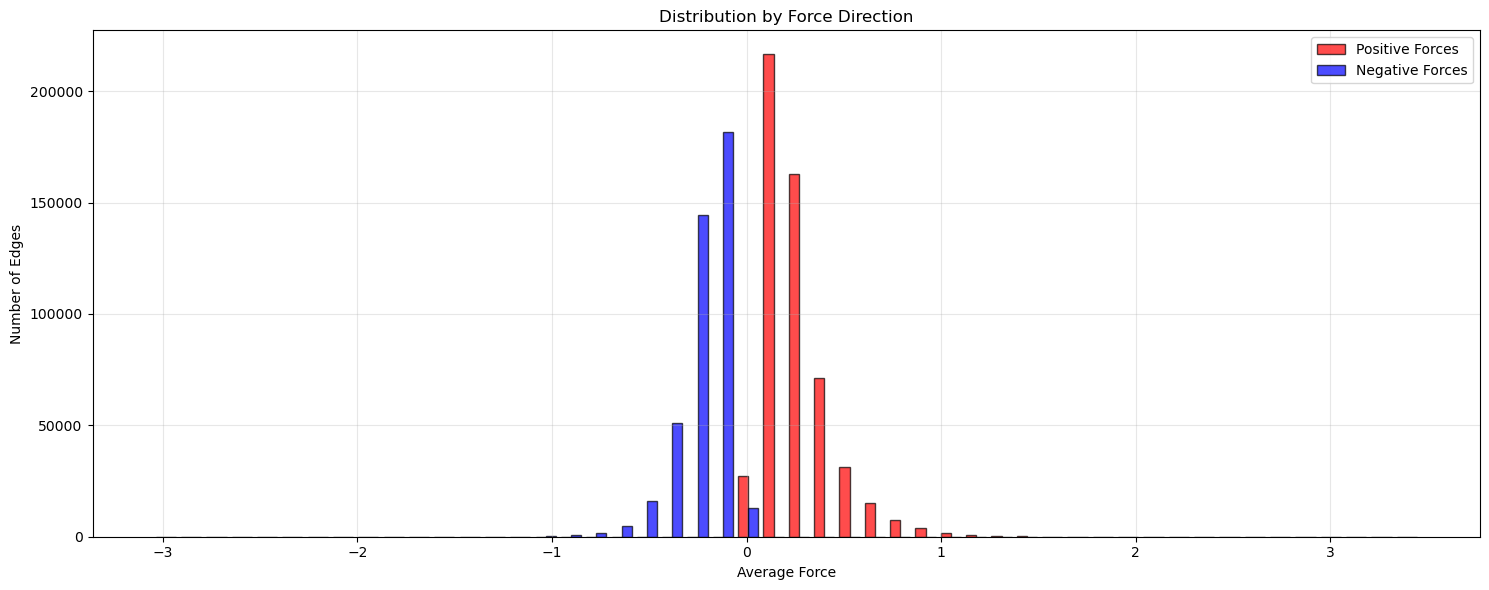

In [96]:
# Get summary statistics for average forces
print("Average force distribution statistics:")
print(f"Total edges: {len(avg_force):,}")
print(f"Mean: {avg_force.mean():.6f}")
print(f"Median: {avg_force.median():.6f}")
print(f"Std: {avg_force.std():.6f}")
print(f"Min: {avg_force.min():.6f}")
print(f"Max: {avg_force.max():.6f}")

# Calculate percentiles
percentiles = [50, 75, 90, 95, 97, 98, 99]
print(f"\nPercentile analysis:")
for p in percentiles:
    threshold = np.percentile(np.abs(avg_force), p)
    count_above = sum(np.abs(avg_force) >= threshold)
    percentage = (count_above / len(avg_force)) * 100
    print(f"{p}th percentile: {threshold:.6f} ({count_above:,} edges = {percentage:.2f}%)")

# Plot distribution
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

# Separate positive and negative forces
positive_forces = avg_force[avg_force > 0]
negative_forces = avg_force[avg_force < 0]

axes.hist([positive_forces, negative_forces], bins=50, alpha=0.7, 
              color=['red', 'blue'], label=['Positive Forces', 'Negative Forces'], edgecolor='black')
axes.set_xlabel('Average Force')
axes.set_ylabel('Number of Edges')
axes.set_title('Distribution by Force Direction')
axes.legend()
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Select the top k% of edges to build the episodic GRN

In [110]:
# Calculate the (100-k)th percentile threshold using absolute values
threshold = np.percentile(np.abs(avg_force), 98.5)
# Create a boolean mask for edges above the threshold
top_percent_mask = np.abs(avg_force) >= threshold
# Create separate dataframe with top k% edges
top_percent_df = avg_force[top_percent_mask].copy()
episodic_grn_edges = top_percent_df.to_frame(name='avg_force')
display(episodic_grn_edges)
# display the unique tf and target numbers
display(len(episodic_grn_edges.index.get_level_values(0).unique()))
display(len(episodic_grn_edges.index.get_level_values(1).unique()))

avg_force
TF      Target           
AHR     ABCC1    1.266435
        ABHD18   0.972516
        ACADVL   0.918565
        ACAP1    1.092982
        ACP1     0.803143
...                   ...
ZNF860  NRF1    -0.880500
ZNF98   BATF3    0.772418
        BPTF     0.937307
        MBD2     0.901591
ZSCAN30 NFYB     0.801946

[14274 rows x 1 columns]

363

5696

## Get the TFs acting on LF genes

In [56]:
# load LF files 
z11_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z11_GC_PB.txt'
z3_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z3_GC_PB.txt'
# load into a list of gene names 
z11 = pd.read_csv(z11_file, sep='\t', header=0)
z3 = pd.read_csv(z3_file, sep='\t', header=0)
# remove HLA- genes
z11 = z11[~z11['names'].str.contains('HLA-')]
z3 = z3[~z3['names'].str.contains('HLA-')]

In [57]:
# get the gene names 
z11_genes = z11['names'].tolist()
z3_genes = z3['names'].tolist()
# create a list of all lf genes 
lf_genes = list(set(z11_genes + z3_genes))
lf_in_object = check_if_gene_in_ndict(dictys_dynamic_object, lf_genes, return_index=True)
print(f"Found {len(lf_in_object['present'])} genes")
print(f"Missing {len(lf_in_object['missing'])} genes")
print("Indices:", lf_in_object['indices'])

Found 57 genes
Missing 0 genes
Indices: {'SUB1': 9706, 'CPEB4': 2131, 'TIAM1': 10070, 'GAB1': 3613, 'CEP128': 1733, 'PIM2': 7239, 'CD74': 1586, 'MAN1A1': 5488, 'CD52': 1574, 'TXNDC5': 10727, 'CD79A': 1587, 'XBP1': 11200, 'IRF4': 4652, 'LMAN1': 5269, 'FNDC3B': 3517, 'ARFGAP3': 560, 'SEL1L3': 8763, 'JCHAIN': 4730, 'DEK': 2479, 'MZB1': 6199, 'PPIB': 7507, 'B2M': 872, 'SSR1': 9582, 'MED23': 5675, 'TRAM2': 10473, 'CTSH': 2270, 'SLA': 8982, 'PAX5': 6943, 'PDE4D': 7027, 'CD99': 1598, 'CIITA': 1884, 'IQGAP2': 4638, 'PRDM1': 7604, 'MAPK1': 5543, 'SLC25A13': 9042, 'TXNDC11': 10722, 'UBAC2': 10759, 'FNDC3A': 3516, 'TBC1D4': 9887, 'SLAMF7': 8987, 'BTG2': 1106, 'IGHM': 4421, 'ELL2': 2979, 'ARNTL2': 665, 'TNFAIP8': 10337, 'ANKRD28': 429, 'PIKFYVE': 7235, 'GLCCI1': 3767, 'CDK6': 1665, 'HSP90B1': 4304, 'RNF213': 8355, 'AFF3': 230, 'EEA1': 2862, 'CCSER2': 1534, 'TRAM1': 10472, 'RUNX2': 8586, 'HM13': 4210}


#### Get the enrichment (over representation) of LF genes in TF regulons

In [111]:
# add a boolean column indicating if the target is a lf gene in the episodic grn df
episodic_grn_edges['is_in_lf'] = episodic_grn_edges.index.get_level_values(1).isin(lf_genes)
# get the number of genes in the episodic grn edges
target_genes_in_episodic_grn = episodic_grn_edges.index.get_level_values(1).unique()
display("Number of targets in episodic grn: ", len(target_genes_in_episodic_grn))
# get the number of lf_genes in the episodic grn edges
lf_in_episodic_grn = episodic_grn_edges[episodic_grn_edges['is_in_lf']]
display(lf_in_episodic_grn.head())
# get the unique LF genes active in the lf_in_episodic_grn df
lf_genes_active_in_episode = lf_in_episodic_grn.index.get_level_values(1).unique()
display("Number of LF genes active in episode: ", len(lf_genes_active_in_episode))
tfs_acting_on_lf = lf_in_episodic_grn.index.get_level_values(0).unique()
display("TFs acting on LF genes: ", tfs_acting_on_lf, len(tfs_acting_on_lf))
# take the tfs in the lf_in_episodic_grn df and subset the episodic_grn_edges df to only include these tfs
episodic_grn_edges_subset = episodic_grn_edges[episodic_grn_edges.index.get_level_values(0).isin(lf_in_episodic_grn.index.get_level_values(0))]
display(episodic_grn_edges_subset.head())
display(episodic_grn_edges_subset.shape)

'Number of targets in episodic grn: '

5696

avg_force  is_in_lf
TF     Target                     
AHR    IRF4    -1.084200      True
       TRAM2    0.987785      True
       XBP1     0.841081      True
ARID3B FNDC3B   0.769651      True
       MAN1A1   1.150797      True

'Number of LF genes active in episode: '

47

'TFs acting on LF genes: '

Index(['AHR', 'ARID3B', 'ARID5A', 'ATF3', 'BACH1', 'BACH2', 'BHLHE40', 'BPTF',
       'CDC5L', 'CEBPB', 'CENPB', 'CREB3L2', 'CTCF', 'E2F4', 'ELF1', 'ELF2',
       'ELK4', 'ETV5', 'FLI1', 'FOXJ3', 'FOXO1', 'GABPA', 'HINFP', 'HMG20A',
       'IKZF1', 'IKZF2', 'IKZF3', 'IRF4', 'IRF5', 'IRF7', 'IRF8', 'IRF9',
       'KLF2', 'MAX', 'MAZ', 'MBD2', 'MBNL2', 'MECP2', 'MEF2A', 'MEF2C',
       'MEF2D', 'MNT', 'MTF2', 'MYC', 'NFAT5', 'NFATC2', 'NFE2L2', 'NFKB1',
       'NFYC', 'NRF1', 'POU2F1', 'POU2F2', 'RBPJ', 'REL', 'RELB', 'RFX7',
       'SMAD4', 'SOX4', 'SP3', 'SREBF1', 'SREBF2', 'ST18', 'STAT3', 'STAT6',
       'TCF12', 'TEAD2', 'TFDP1', 'USF2', 'YY1', 'ZFP14', 'ZFY', 'ZNF254',
       'ZNF281', 'ZNF37A', 'ZNF519', 'ZNF770'],
      dtype='object', name='TF')

76

avg_force  is_in_lf
TF  Target                     
AHR ABCC1    1.266435     False
    ABHD18   0.972516     False
    ACADVL   0.918565     False
    ACAP1    1.092982     False
    ACP1     0.803143     False

(10267, 2)

In [112]:
episodic_enrichment_df = calculate_tf_episodic_enrichment(episodic_grn_edges_subset, 
                                       len(lf_genes_active_in_episode), 
                                       len(target_genes_in_episodic_grn))
# sort the episodic_enrichment_df_p005 by enrichment_score in descending order
episodic_enrichment_df_sorted = episodic_enrichment_df.sort_values(by='enrichment_score', ascending=False)
# filter the episodic_enrichment_df to only include tfs with a p_value < threshold
episodic_enrichment_df_p005 = episodic_enrichment_df_sorted[episodic_enrichment_df_sorted['p_value'] < 0.05]
display(episodic_enrichment_df_p005)

,TF,p_value,enrichment_score,genes_in_lf,genes_dwnstrm,weights
31,IRF9,0.016436,60.595745,"(CEP128,)","(BAZ1A,)","(0.8005695921560232,)"
69,ZFP14,0.016436,60.595745,"(IRF4,)","(RUNX3,)","(1.0984481704846734,)"
22,HINFP,0.016436,60.595745,"(CEP128,)","(MAZ,)","(0.7717791988089001,)"
30,IRF8,0.024555,40.397163,"(RNF213,)","(CD226, SP4)","(-0.77267764845062,)"
70,ZFY,0.024555,40.397163,"(IRF4,)","(CTCF, FOXK2)","(0.7575957916916577,)"
59,SREBF1,0.024555,40.397163,"(RUNX2,)","(TFEC, UBAP2)","(0.7857458458351029,)"
71,ZNF254,0.024555,40.397163,"(CEP128,)","(SSH2, TAF15)","(0.7850650301404973,)"
29,IRF7,0.001808,30.297872,"(B2M, CEP128)","(ELF2, FAM111A, IRF2, KLF2, KLF6, SP4)","(0.789182217047377, 0.7611057525337382)"
65,TEAD2,0.032608,30.297872,"(PAX5,)","(CEBPG, GABPA, ZNF605)","(0.811261497455976,)"
9,CEBPB,0.040596,24.238298,"(RUNX2,)","(MAFG, VTI1A, ZBTB44, ZNF789)","(0.8435969011982717,)"


In [113]:
# save the episodic_enrichment_df_p005_sorted df to a csv file
episodic_enrichment_df_sorted.to_csv(os.path.join(output_folder, 'enrichment_ep4_gc.csv'), index=False)